In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import sys
sys.path.append('../code')
from gplar import GPLARegressor

In [2]:
data = np.load('eeg_exchange.npy', allow_pickle=True).item()

eeg_all,      eeg_train,      eeg_test      = data['eeg']
exchange_all, exchange_train, exchange_test = data['exchange']

## EEG

In [5]:
x_eeg = np.array(eeg_train.index).reshape(256,1)
y_eeg = np.array(eeg_train) 

In [51]:
means_eeg, stds_eeg = [],[]
for i, name in enumerate(eeg_train.columns):
    available = ~np.isnan(y_eeg[:,i])
    y_i = y_eeg[available, i]
    means_eeg.append(np.mean(y_i))
    stds_eeg.append(np.std(y_i))
means_eeg, stds_eeg = np.stack(means_eeg), np.stack(stds_eeg)

def normalise_y(y_, means, stds): return (y_ - means)/stds
def unnormalise_y(y_, means, stds): return y_*stds + means

y_eeg_normalise = normalise_y(y_eeg ,means_eeg, stds_eeg)

In [54]:
from gpar.regression import GPARRegressor
model = GPARRegressor(scale=0.02,
                          linear=False, nonlinear=True, nonlinear_scale=1.0,
                          noise=0.01,
                          impute=True, replace=True, normalise_y=True)
model.fit(x_eeg, y_eeg)
means_ee, lowers_ee, uppers_ee = \
        model.predict(x_eeg, num_samples=100, credible_bounds=True, latent=True)

Training conditionals (total: 7): 1 2 3 4 5 6 7
Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


In [18]:
gpar = GPARRegressor(scale=0.02,
                          linear=False, nonlinear=True, nonlinear_scale=1.0,
                          noise=0.01,
                          impute=True, replace=True, normalise_y=False)
M = 256

m_c_eeg = GPLARegressor(x_eeg, y_eeg_normalise, M, gpar, white=False,
                 scale=0.02,
                 linear=False,
                 nonlinear=True, nonlinear_scale=1.0,
                 noise_inner=1e-5, noise_obs=0.01,
                 num_samples=1)

Training conditionals (total: 7): 1 2 3 4 5 6 7
Sampling (total: 200): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200


In [84]:
@tf.function(autograph=False)
def optimization_step(optimizer, model, data):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = -model.maximum_log_likelihood_objective(*data)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, data, iterations):
    logf=[]
    adam = tf.optimizers.Adam(0.001)
    for step in range(iterations):
        neg_elbo = optimization_step(adam, model, data)
        elbo = -neg_elbo
        if step%50 == 0:
            logf.append(elbo.numpy())
        if step%500 == 0:
            print(elbo.numpy())
    return logf

In [20]:
from gpflow.ci_utils import ci_niter
maxiter = ci_niter(4000)
logf = run_adam(m_c_eeg, (x_eeg,y_eeg_normalise), maxiter)

-169233.09194117718
-2197.003109357769
-1091.7102970791607
-730.9470088956446
-585.7776610227414
-481.6987670768649
-406.642794358806
-305.4459020281872


In [56]:
maxiter = ci_niter(2000)
logf = run_adam(m_c_eeg, (x_eeg,y_eeg_normalise), maxiter)

-221.56423994093575
390.34514734782806
656.8958743461826
779.626253573942


In [85]:
maxiter = ci_niter(1000)
logf = run_adam(m_c_eeg, (x_eeg,y_eeg_normalise), maxiter)

824.7275460284716
852.8336319396676


In [86]:
Hmeans_c, Hvars_c = m_c_eeg.predict_f(x_eeg, 100)
def getMeanandBound(Hmeans,Hvars):
    Hmeans, Hvars = np.squeeze(np.stack(Hmeans, axis=2)), np.squeeze(np.stack(Hvars,axis=2))
    mean, std = np.mean(Hmeans,axis=0), np.sqrt(np.mean(Hvars, axis=0))
    mean, std = unnormalise_y(mean, means_eeg, stds_eeg), stds_eeg*std
        
    return mean, mean-1.96*std, mean+1.96*std
predict_y_eeg = getMeanandBound(Hmeans_c, Hvars_c)

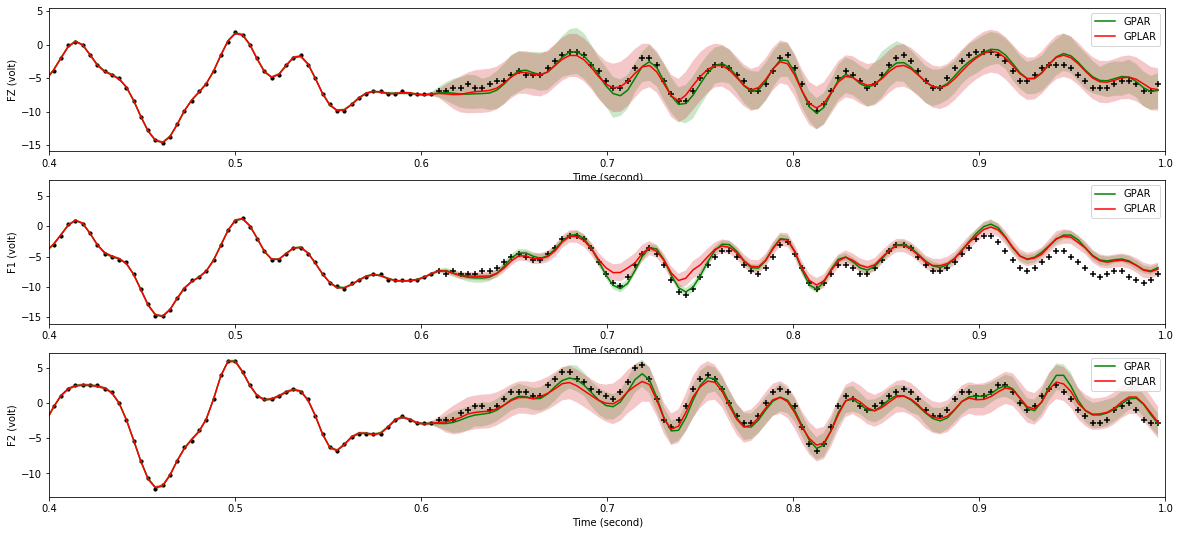

In [87]:
plt.figure(figsize=(20, 9))
x = np.array(eeg_train.index)
for i, name in enumerate(eeg_test.columns):
    p = list(eeg_train.columns).index(name)  # Index of output.
    plt.subplot(3, 1, i + 1)
    plt.plot(x, means_ee[:, p], c='green', label='GPAR')
    plt.fill_between(x, lowers_ee[:, p], uppers_ee[:, p], facecolor='tab:green', alpha=.25)
    plt.plot(x, predict_y_eeg[0][:,p], c='red', label = 'GPLAR')
    plt.fill_between(x, predict_y_eeg[1][:, p], predict_y_eeg[2][:, p], facecolor='tab:red', alpha=.25)
    plt.scatter(x, y_eeg[:, p], c='black', s=10)
    plt.scatter(eeg_test[name].index, eeg_test[name], c='black', marker= '+')
    plt.xlabel('Time (second)')
    plt.xlim(0.4, 1)
    plt.ylabel(f'{name} (volt)')
    plt.legend()
plt.savefig('eeg.png', dpi=400)

In [88]:
import pandas as pd
pred_ee = pd.DataFrame(means_ee, index=eeg_train.index, columns=eeg_train.columns)
smse_ee = ((pred_ee - eeg_test) ** 2).mean().mean() / \
           ((eeg_test.mean(axis=0) - eeg_test) ** 2).mean().mean()
    
pred_ee_GPLAR = pd.DataFrame(predict_y_eeg[0], index=eeg_train.index, columns=eeg_train.columns)
smse_ee_GPLAR = ((pred_ee_GPLAR - eeg_test) ** 2).mean().mean() / \
           ((eeg_test.mean(axis=0) - eeg_test) ** 2).mean().mean()

print('SMSE-eeg-GPAR:', smse_ee)
print('SMSE-eeg-GPLAR:', smse_ee_GPLAR)

SMSE-eeg-GPAR: 0.21512445551149448
SMSE-eeg-GPLAR: 0.22957513269909904


## EXCHANGE

In [65]:
x_ex = np.array(exchange_train.index).reshape(251, 1)
y_ex = np.array(exchange_train) 

In [63]:
means_exchange, stds_exchange = [],[]
for i, name in enumerate(exchange_train.columns):
    available = ~np.isnan(y_ex[:,i])
    y_i = y_ex[available, i]
    means_exchange.append(np.mean(y_i))
    stds_exchange.append(np.std(y_i))
means_exchange, stds_exchange = np.stack(means_exchange), np.stack(stds_exchange)

In [64]:
y_ex_normalise = normalise_y(y_ex, means_exchange, stds_exchange)

In [77]:
model = GPARRegressor(scale=0.1,
                          linear=True, linear_scale=10.,
                          nonlinear=True, nonlinear_scale=1.,
                          rq=True,
                          noise=0.01,
                          impute=True, replace=True, normalise_y=True)
model.fit(x_ex, y_ex)
means_ex, lowers_ex, uppers_ex = \
    model.predict(x_ex, num_samples=100, credible_bounds=True, latent=False)

Training conditionals (total: 13): 1 2 3 4 5 6 7 8 9 10 11 12 13
Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


In [67]:
gpar = GPARRegressor(scale=0.1,
                          linear=True, linear_scale=10.,
                          nonlinear=True, nonlinear_scale=1.,
                          rq=True,
                          noise=0.01,
                          impute=True, replace=True, normalise_y=False)
M = 251

m_c_exchange = GPLARegressor(x_ex, y_ex_normalise, M, gpar, white=False,
                 scale=0.1,
                 linear=True, linear_scale=10.,
                 nonlinear=True, nonlinear_scale=1.,
                 rq=True,
                 noise_inner=1e-5, noise_obs=0.01,
                 num_samples=1)

Training conditionals (total: 13): 1 2 3 4 5 6 7 8 9 10 11 12 13
Sampling (total: 200): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200


In [68]:
@tf.function(autograph=False)
def optimization_step(optimizer, model, data):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = -model.maximum_log_likelihood_objective(*data)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, data, iterations):
    logf=[]
    adam = tf.optimizers.Adam(0.001)
    for step in range(iterations):
        neg_elbo = optimization_step(adam, model, data)
        elbo = -neg_elbo
        if step%50 == 0:
            logf.append(elbo.numpy())
        if step%300 == 0:
            print(elbo.numpy())
    return logf

from gpflow.ci_utils import ci_niter
maxiter = ci_niter(5000)
logf = run_adam(m_c_exchange, (x_ex, y_ex_normalise), maxiter)

-23988.67779621995
-2631.3508275420872
-1131.210632532552
-368.08564419611525
-70.99519562433511
130.8167120840651
186.60632593861942
237.30559175855683
270.7891433124714
272.23294816259
361.1312874612195
377.895656237014
404.43891965595344
418.58610061115087
459.68481585445534
476.51898124913305
456.51381143648814


In [71]:
Hmeans_c, Hvars_c = m_c_exchange.predict_f(x_ex, 100)
def getMeanandBound(Hmeans,Hvars):
    Hmeans, Hvars = np.squeeze(np.stack(Hmeans, axis=2)), np.squeeze(np.stack(Hvars,axis=2))
    mean, std = np.mean(Hmeans,axis=0), np.sqrt(np.mean(Hvars, axis=0))
    mean, std = unnormalise_y(mean, means_exchange, stds_exchange), stds_exchange*std
        
    return mean, mean-1.96*std, mean+1.96*std
predict_y_exchange = getMeanandBound(Hmeans_c, Hvars_c)

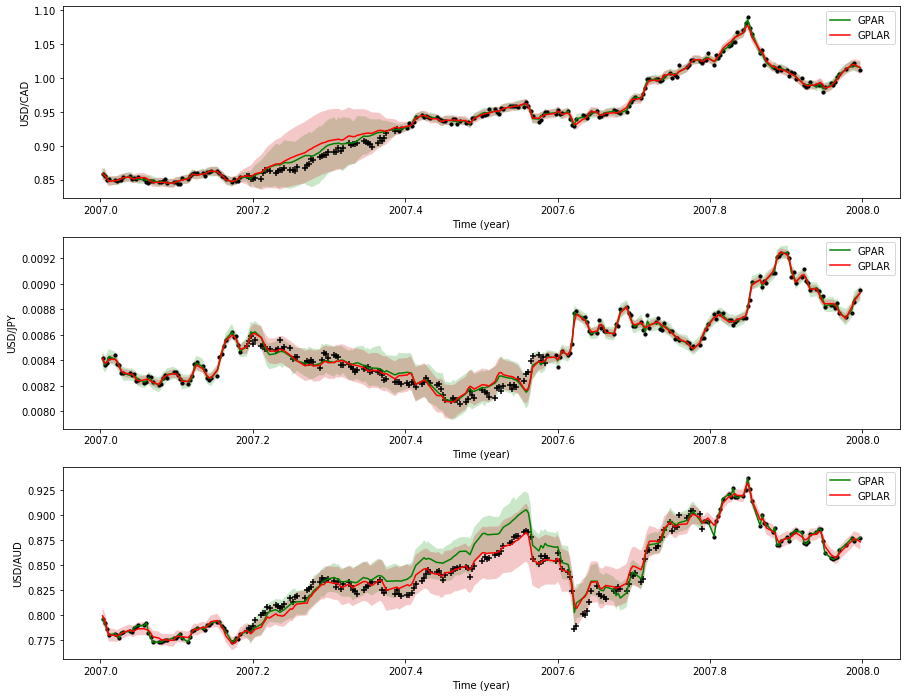

In [79]:
plt.figure(figsize=(15, 12))
x = np.array(exchange_train.index)
for i, name in enumerate(exchange_test.columns):
    p = list(exchange_train.columns).index(name)  # Index of output.
    plt.subplot(3, 1, i + 1)
    plt.plot(x, means_ex[:, p], c='green', label='GPAR')
    plt.fill_between(x, lowers_ex[:, p], uppers_ex[:, p], facecolor='tab:green', alpha=.25)
    plt.plot(x, predict_y_exchange[0][:,p], c='red', label = 'GPLAR')
    plt.fill_between(x, predict_y_exchange[1][:, p], predict_y_exchange[2][:, p], facecolor='tab:red', alpha=.25)
    plt.scatter(x, y_ex[:, p], c='black', s=10)
    plt.scatter(exchange_test[name].index, exchange_test[name], c='black', marker= '+')
    plt.xlabel('Time (year)')
    plt.ylabel(name)
    plt.legend()
plt.savefig('exchange.png', dpi=300)

In [83]:
pred_ex = pd.DataFrame(means_ex, index=exchange_train.index, columns=exchange_train.columns)
smse_ex = ((pred_ex - exchange_test) ** 2).mean(axis=0) / \
           ((exchange_train.mean(axis=0) - exchange_test) ** 2).mean(axis=0)
    
pred_ex_GPLAR = pd.DataFrame(predict_y_exchange[0], index=exchange_train.index, columns=exchange_train.columns)
smse_ex_GPLAR = ((pred_ex_GPLAR - exchange_test) ** 2).mean(axis=0) / \
           ((exchange_train.mean(axis=0) - exchange_test) ** 2).mean(axis=0)
    
print('SMSE-exchange-GPAR:')
print('USD/CAD:', smse_ex['USD/CAD'])
print('USD/JPY:', smse_ex['USD/JPY'])
print('USD/AUD:', smse_ex['USD/AUD'])
print('SMSE-exchange-GPLAR:')
print('USD/CAD:', smse_ex_GPLAR['USD/CAD'])
print('USD/JPY:', smse_ex_GPLAR['USD/JPY'])
print('USD/AUD:', smse_ex_GPLAR['USD/AUD'])

SMSE-exchange-GPAR:
USD/CAD: 0.017891059169982893
USD/JPY: 0.02426940516561255
USD/AUD: 0.18825493952823832
SMSE-exchange-GPLAR:
USD/CAD: 0.04143483322603091
USD/JPY: 0.02536026562709996
USD/AUD: 0.06554447799135155
